In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from ud_sac import UDSAC, rollout, sample_episode, train, evaluate_agent, set_seed
from core import Episode

from joblib import Parallel, delayed

In [2]:
def evaluate_agent_mp(env_name, agent, desired_return_range, desired_horizon_range, num=50, n_jobs=1, seed=42):
    return_grid = np.linspace(desired_return_range[0], desired_return_range[1], num)
    horizon_grid = np.linspace(desired_horizon_range[0], desired_horizon_range[1], num)
    
    env = gym.make(env_name)
    set_seed(env, seed=seed)

    actual_desired_error = np.zeros((num, num))
    
    pool = []
    for i, desired_reward in enumerate(return_grid):
        for j, desired_horizon in enumerate(horizon_grid):
            pool.append(delayed(rollout)(env, agent, desired_reward, desired_horizon))
            
    outcomes = Parallel(n_jobs=4)(pool)
    
    for idx, (actual_reward, actual_horizon) in enumerate(outcomes):
        i, j = divmod(idx, num)
        
        desired_reward, desired_horizon = return_grid[i], horizon_grid[j]
        actual_desired_error[i, j] = np.abs(desired_reward - actual_reward) + np.abs(desired_horizon - actual_horizon)

    return return_grid, horizon_grid, actual_desired_error

In [2]:
agent = torch.load("trained_agents/CartPoleAgent.pt", map_location="cpu")

dr, dh, err = evaluate_agent("CartPole-v0", agent, (10, 190), (10, 190), num=15)

In [3]:
err.mean(), err.std()

(138.66031746031746, 79.66808747709145)

In [4]:
np.diag(e)

array([ 0.        ,  5.71428571,  5.42857143,  5.14285714,  6.85714286,
        4.57142857,  6.28571429, 12.        ,  9.71428571, 11.42857143,
        1.14285714,  4.85714286,  2.57142857,  2.28571429,  2.        ])

# Buffer test

In [2]:
# def plot_agent_perf(env, agent, test_episodes=10):
#     desired_returns = np.linspace(10, 195, 50)
    
#     actual_returns = [[rollout(env, agent, dr, dr)[0] for _ in range(test_episodes)] for dr in desired_returns]
#     actual_returns = np.stack(actual_returns)
    
#     actual_means, actual_stds = actual_returns.mean(axis=1), actual_returns.std(axis=1)
    
#     plt.figure(figsize=(12, 8))
#     plt.plot(desired_returns, actual_means);
#     plt.fill_between(desired_returns, actual_means - actual_stds, actual_means + actual_stds)
#     plt.xlabel("Desired return")
#     plt.ylabel("Actual return")
#     plt.title("CartPole-v0");

def plot_err_heatmap(dr, dh, err):
    err_log = np.log10(err)

    plt.figure(figsize=(10, 8))
    plt.pcolormesh(dr, dh, err_log, vmin=err_log.min(), vmax=err_log.max(), cmap='RdYlGn_r', shading="auto")
    plt.xlabel("Desired return")
    plt.ylabel("Desired horizon")
    plt.title("LunarLander-v2")

    cbar = plt.colorbar()
    cbar.set_label("Log Absolute Error", rotation=0, labelpad=55);

In [11]:
agent = torch.load("udsac_test.pt", map_location="cpu")
env = gym.make("LunarLander-v2")

dr, dh, err = evaluate_agent("LunarLander-v2", agent, (-300, 300), (50, 400), num=15)
err.mean()

419.31640268728836

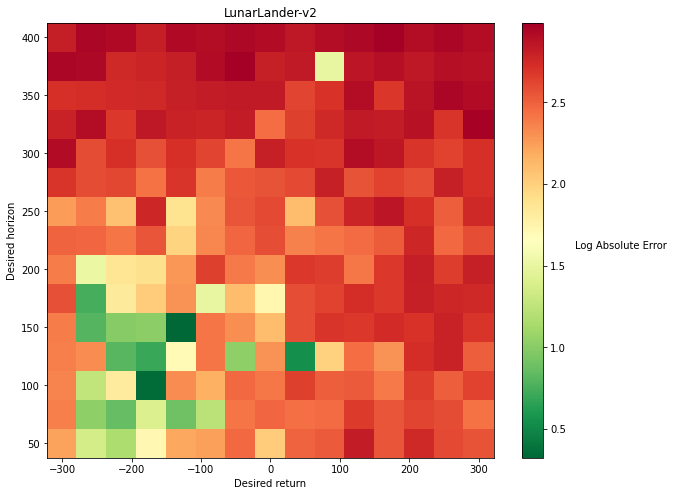

In [12]:
plot_err_heatmap(dr, dh, err)

# Rewards

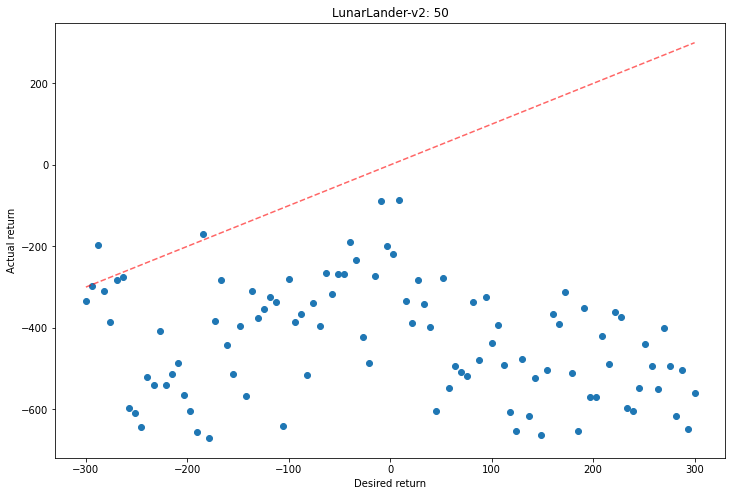

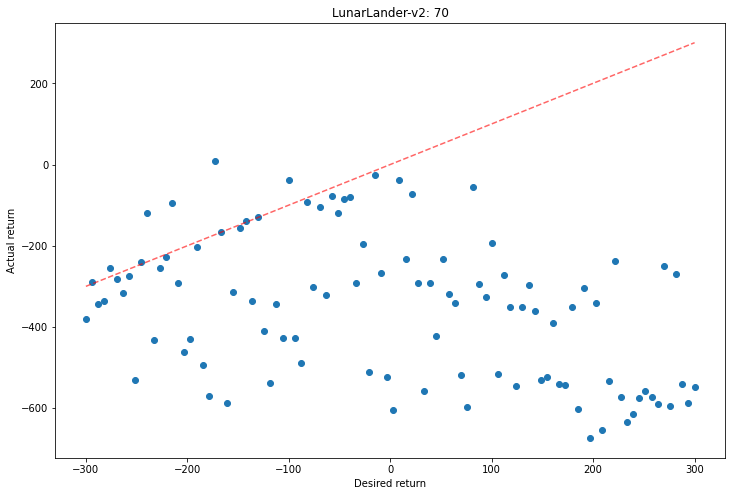

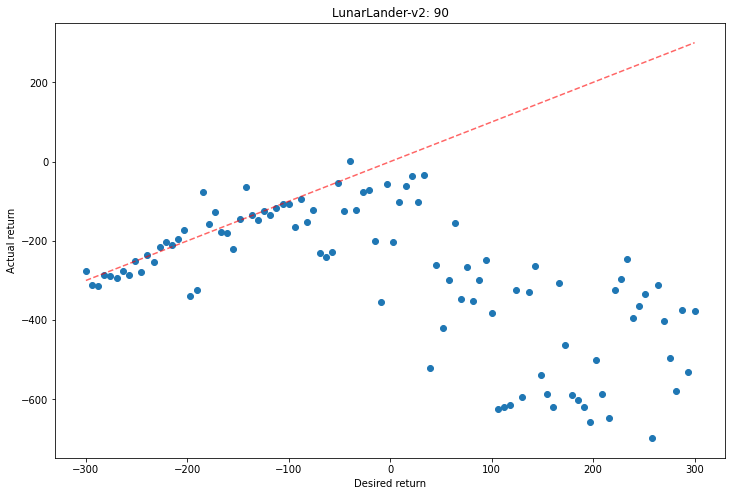

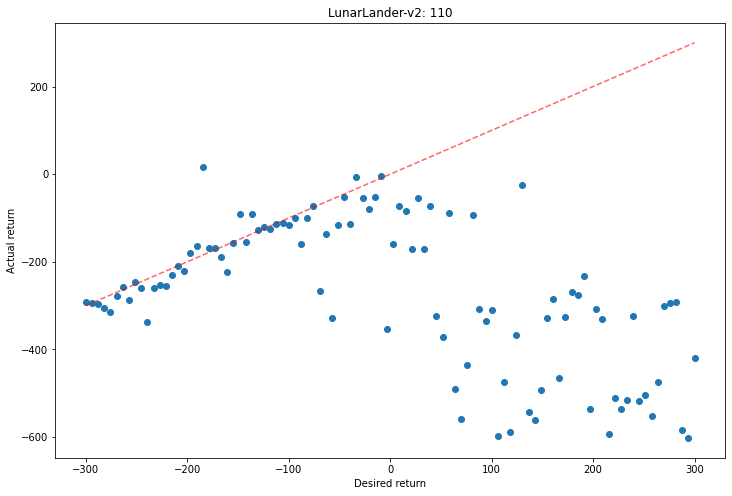

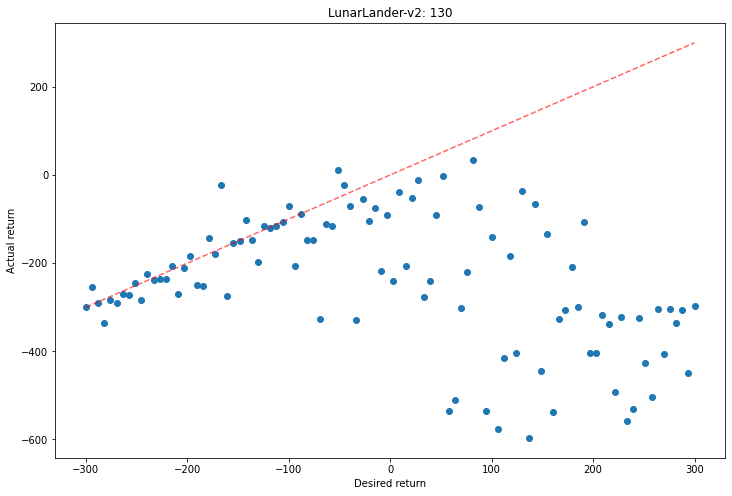

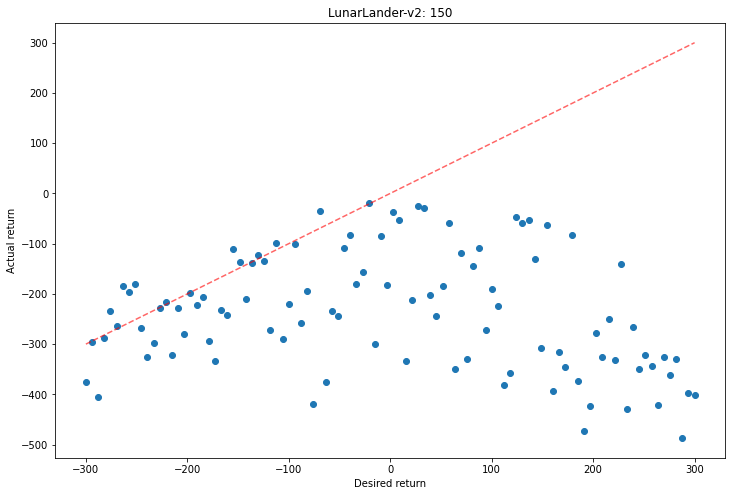

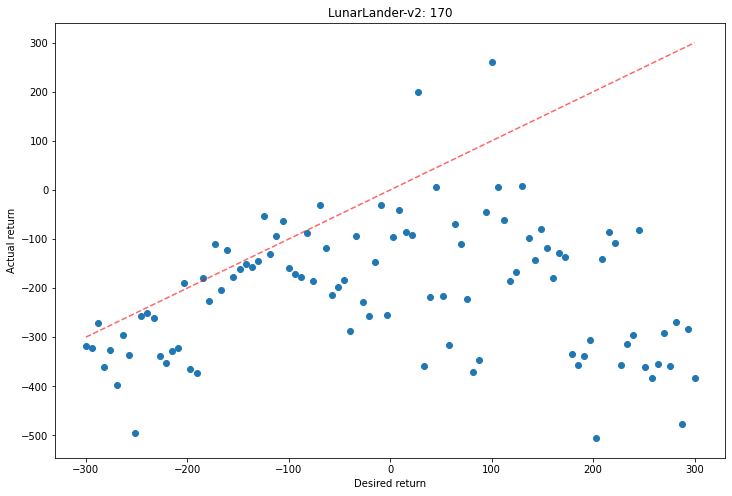

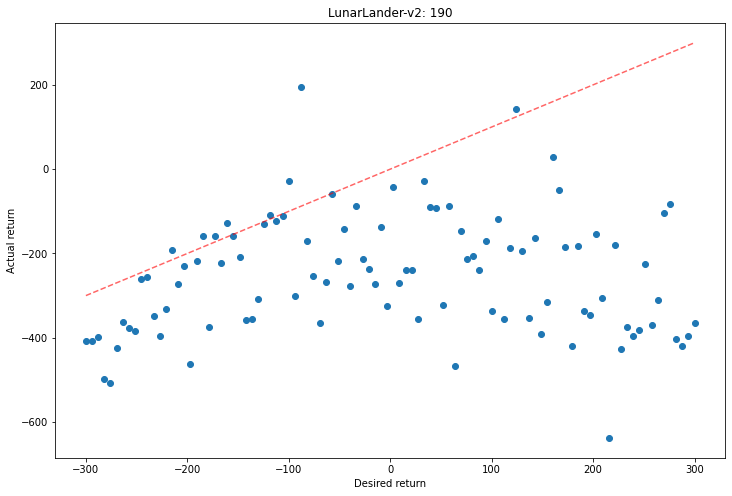

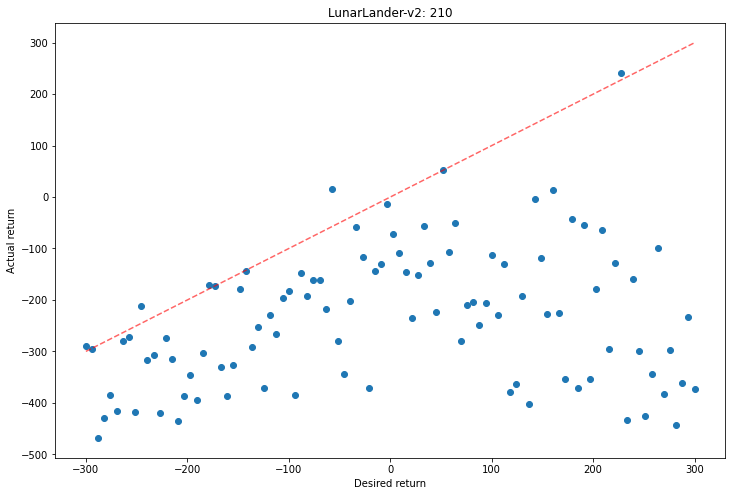

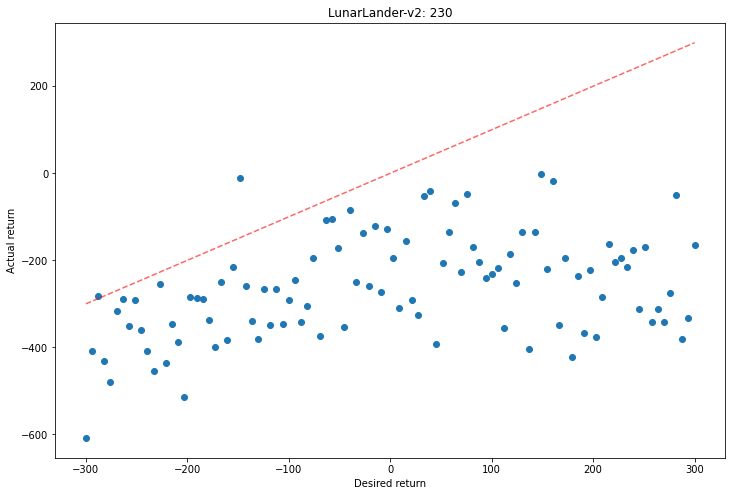

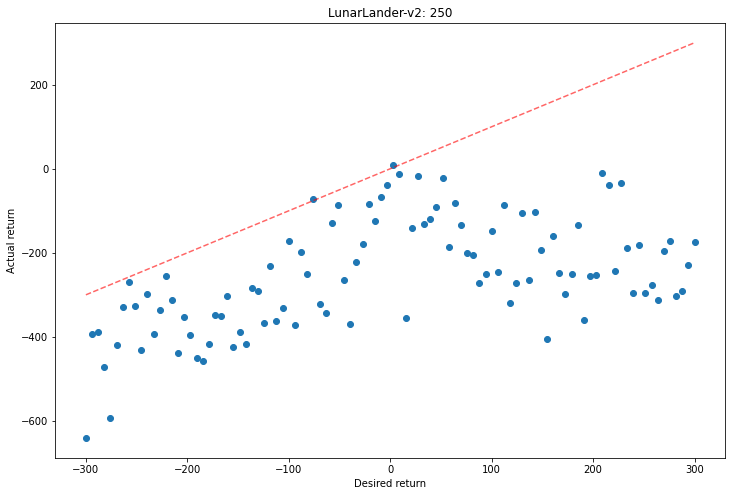

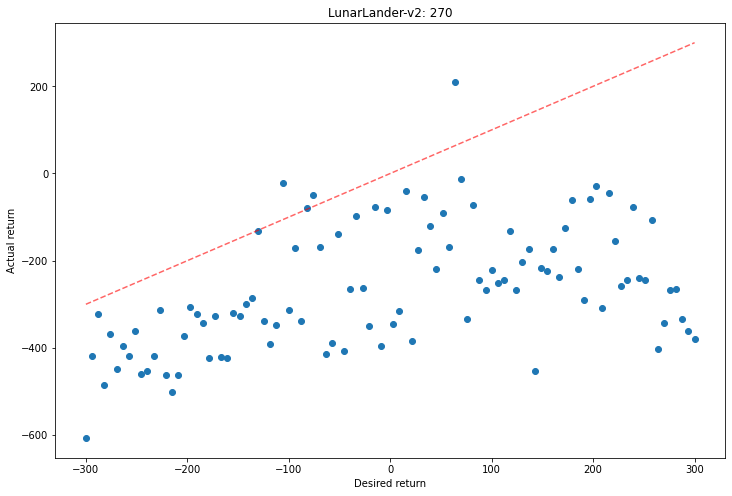

In [13]:
for desired_horizon in np.arange(50, 280, 20):
    desired_returns = np.linspace(-300, 300, 100)

    actual_returns = [rollout(env, agent, dr, desired_horizon)[0] for dr in desired_returns]

    plt.figure(figsize=(12, 8))
    plt.scatter(desired_returns, actual_returns);
    plt.plot(desired_returns, desired_returns, "--", color="red", alpha=0.6)
    plt.xlabel("Desired return")
    plt.ylabel("Actual return")
    plt.title(f"LunarLander-v2: {desired_horizon}");

# Horizons

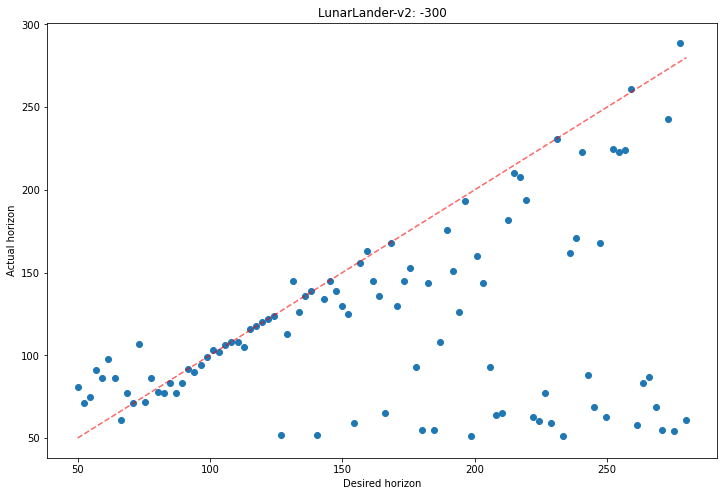

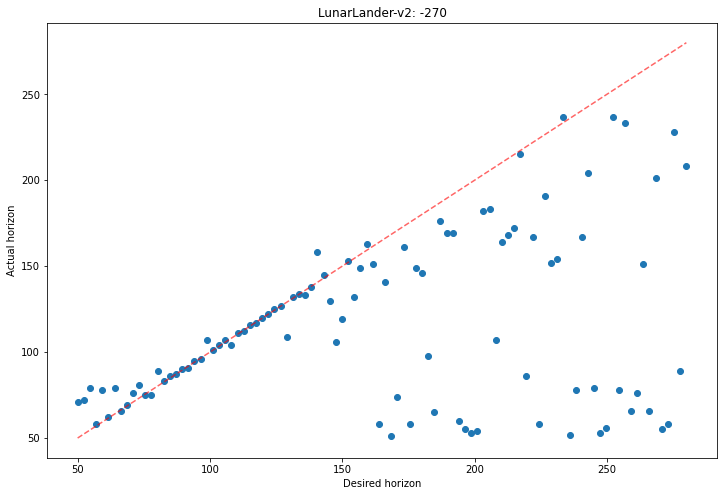

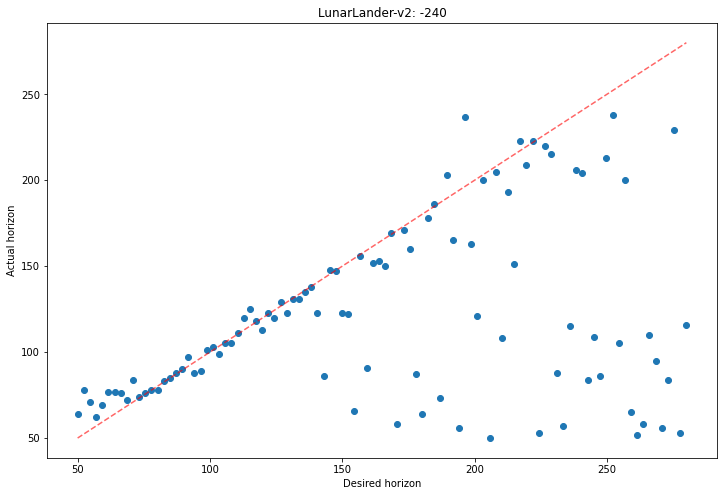

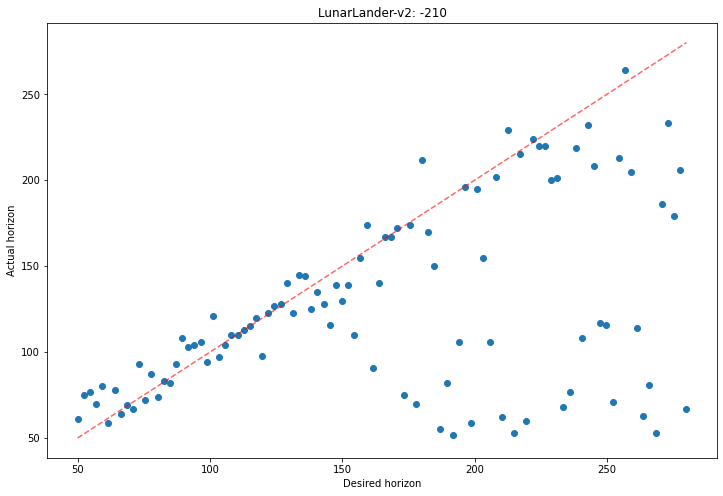

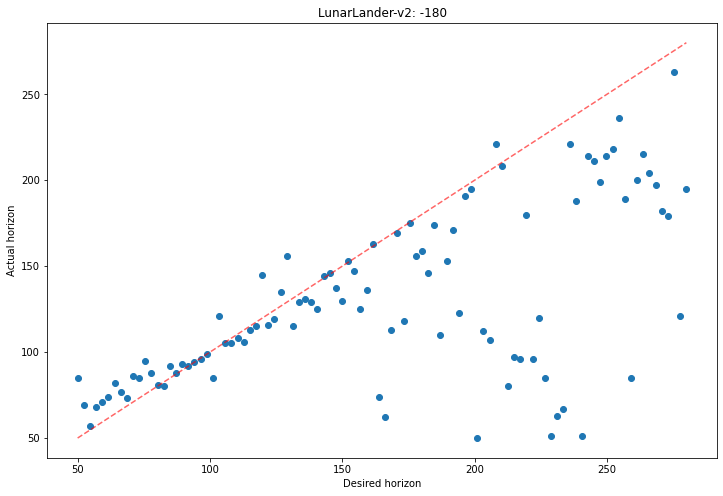

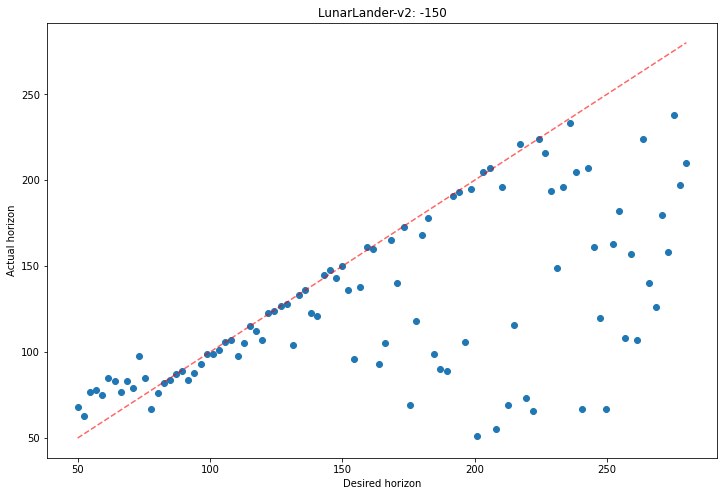

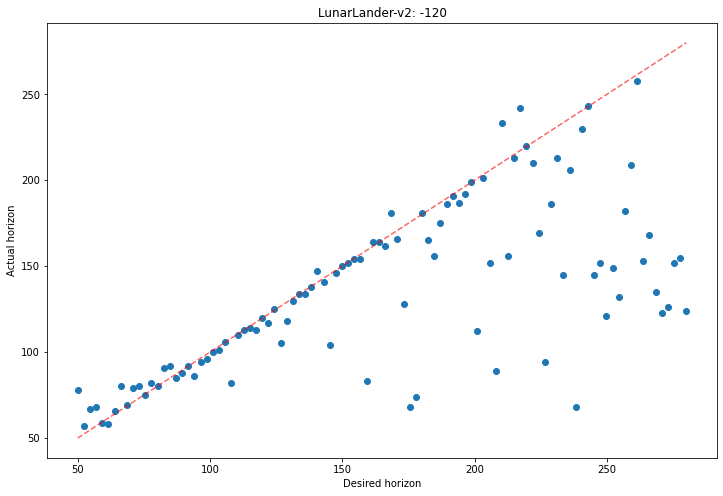

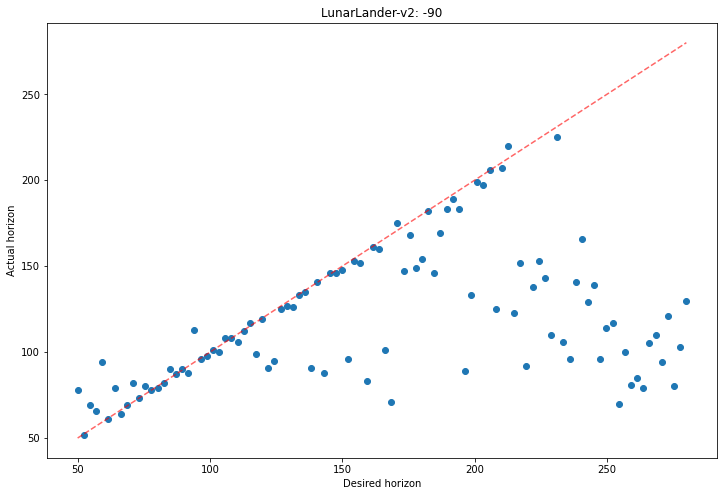

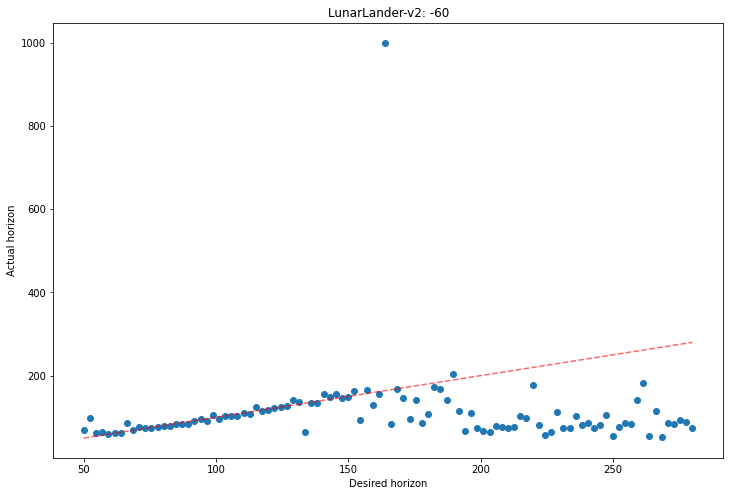

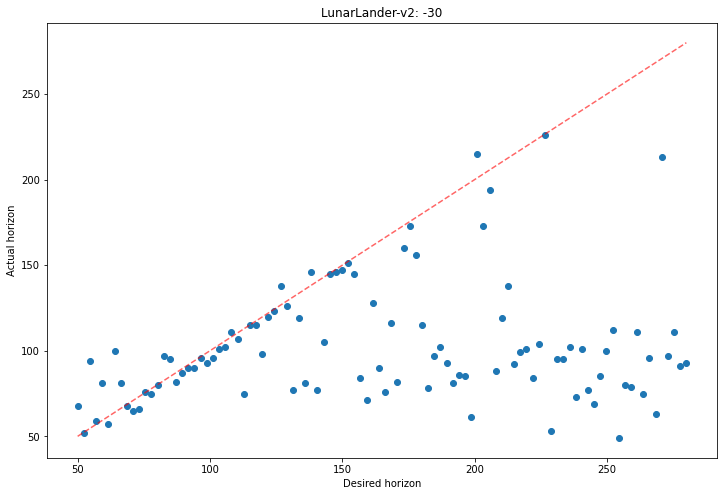

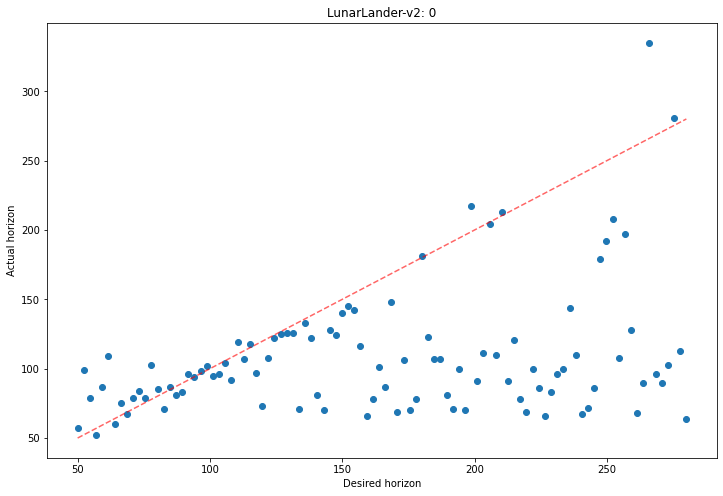

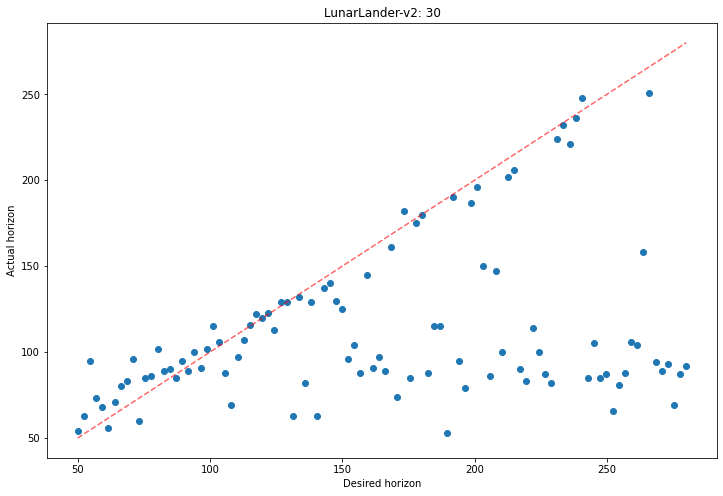

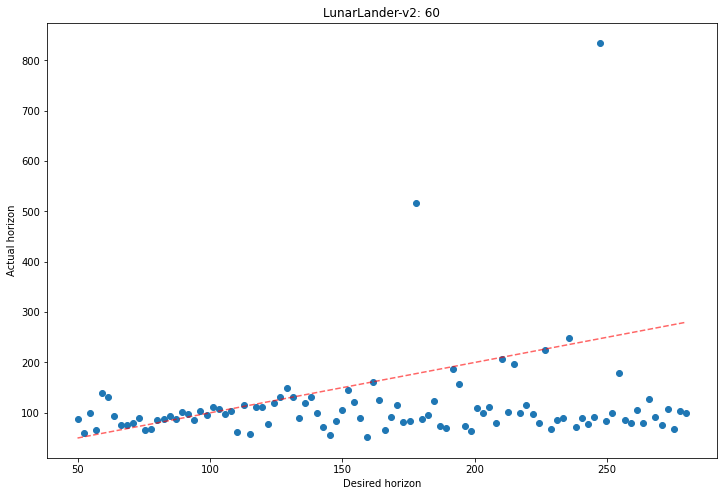

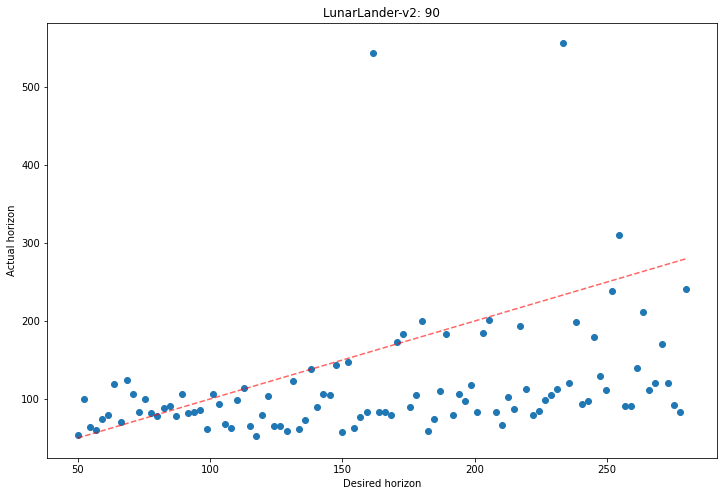

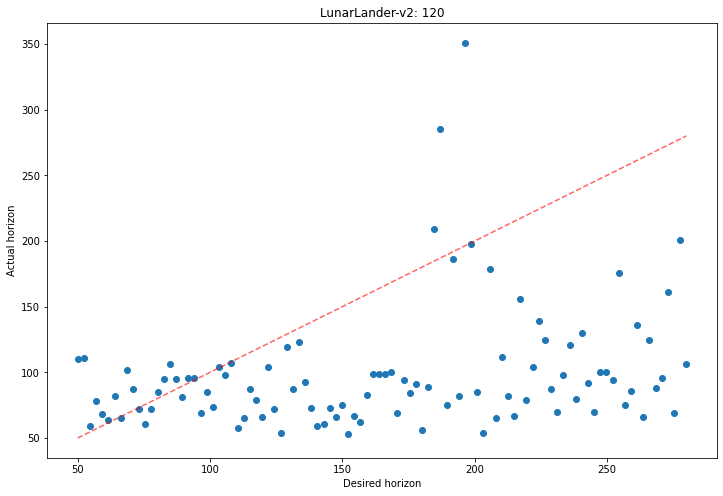

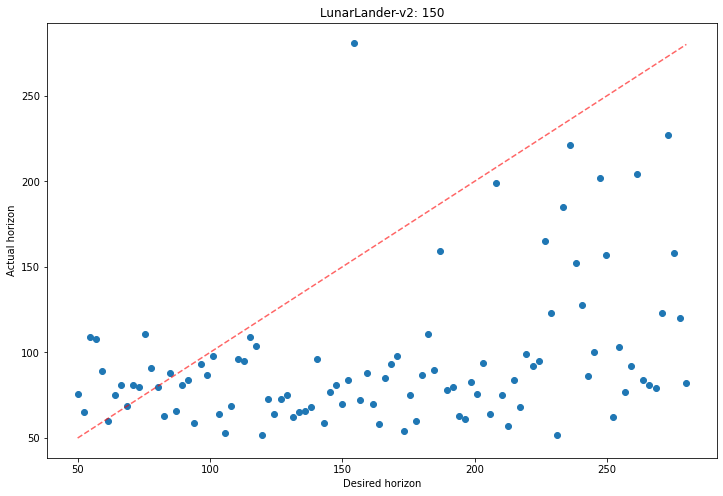

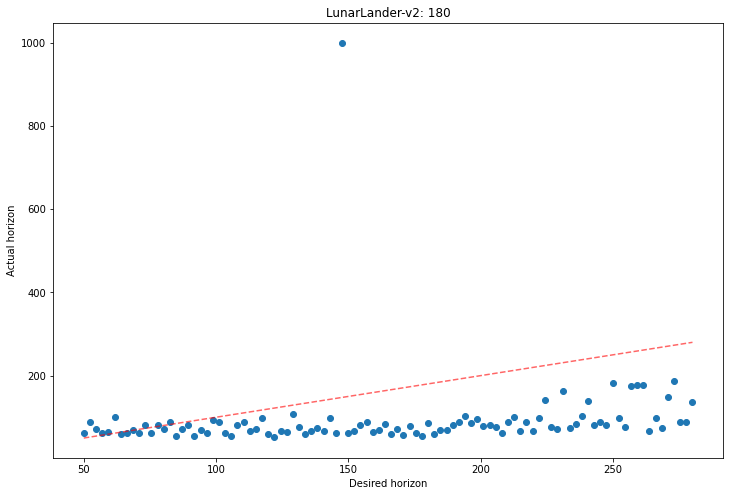

In [14]:
for desired_reward in np.arange(-300, 200, 30):
    desired_horizons = np.linspace(50, 280, 100)

    actual_horizons = [rollout(env, agent, desired_reward, dh)[1] for dh in desired_horizons]

    plt.figure(figsize=(12, 8))
    plt.scatter(desired_horizons, actual_horizons);
    plt.plot(desired_horizons, desired_horizons, "--", color="red", alpha=0.6)
    plt.xlabel("Desired horizon")
    plt.ylabel("Actual horizon")
    plt.title(f"LunarLander-v2: {desired_reward}");